In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from collections import defaultdict
from scipy.sparse import dok_matrix, csr_matrix
from sklearn.preprocessing import normalize
import networkx as nx
import itertools
from itertools import islice
from tqdm.notebook import tqdm
from matplotlib.patches import Patch
import scipy as sp
import math
import csv
from collections import OrderedDict
import sys
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap


mpl.rcParams['figure.dpi'] = 100
plt.rcParams.update({'font.size': 7,'axes.linewidth':0.5,
                     'xtick.major.size':2,'xtick.major.width':0.5,
                    'ytick.major.size':2,'ytick.major.width':0.5})
plt.rcParams.update({'mathtext.default':  'regular' })


colorMA90, colorSI06, colorG189E = "#E8735C", "#72C2A6", "#5482A7"


#### antibody choice ####
antibody = "CH65"
antigens = ["MA90", "SI06", "G189E"]
L = 16
sequences_int = range(2**L)


#### selection model choice ####
#model = 'strong'
model = 'moderate'
#model = 'weak'
################################

if model == 'moderate':
    N = 1000
    gamma = 1.0
elif model == 'weak':
    N = 20
    gamma = 0.5

Nbootstrap = 10


# define some functions
def mutation(s, ii, L):
    """ Return the sequence (in int format) with base s,
        with a somatic mutation at pos ii """
    return s | 2**(L-1-ii)

def nb_mutation(s):
    """ Number of mutations in variant s """
    return bin(s).count("1")

def reachable(s, L):
    return [(s | 2**ii) for ii in range(L) if (s | 2**ii) > s]

def k_shortest_paths(G, source, target, k, weight=None):
    return list(
        islice(nx.shortest_simple_paths(G, source, target, weight=weight), k)
    )
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


#can add a constraint to pass thru intermediate here
# example
is_intermediate = False
INTERMEDIATE = int('0000001010100000', 2)
nb_mut_int = nb_mutation(INTERMEDIATE)
force_intermediate = dok_matrix((2**L, 2**L), dtype=np.float64)
for mut in range(L):
    t = mutation(INTERMEDIATE, mut, L)
    force_intermediate[INTERMEDIATE, t] = 1
    

# define data and image folder
data = ""
img = ""
##############################

## Load data

In [2]:
# read dataframe
df = pd.read_csv(f"../Kd_inference/results_CH65/Kds/Kd_processed/20220430_CH65_filt.csv", dtype={"geno":"str"})
df = df.rename(columns={"MA90_mean": "MA90_log10Kd", "SI06_mean": "SI06_log10Kd","G189E_mean": "G189E_log10Kd",
                        "MA90_sem": "MA90_stelog10Kd", "SI06_sem": "SI06_stelog10Kd", "G189E_sem": "G189E_stelog10Kd"})

# convert genotypes to integers and sort accordingly    
df["variant_int"] = df.geno.apply(lambda x: int(x, 2))
df = df.set_index("variant_int").reindex(range(0, 2**L)).reset_index()

for ii in range(L):
    df[f"mutation_{ii+1}"] = df.geno.str[ii] == '1'
      
# get average Kd for mixed scenarios    
df['mixed_log10Kd'] = df[[f"{a}_log10Kd" for a in antigens]].mean(axis=1)
df

,variant_int,geno,repa_x,repb_x,MA90_log10Kd,MA90_stelog10Kd,repa_y,repb_y,SI06_log10Kd,SI06_stelog10Kd,...,mutation_8,mutation_9,mutation_10,mutation_11,mutation_12,mutation_13,mutation_14,mutation_15,mutation_16,mixed_log10Kd
0,0,0000000000000000,8.608953,8.465614,8.537283,0.041378,6.000000,6.000000,6.000000,0.000000,...,False,False,False,False,False,False,False,False,False,6.845761
1,1,0000000000000001,8.631288,8.508996,8.570142,0.035303,6.000000,6.000000,6.000000,0.000000,...,False,False,False,False,False,False,False,False,True,6.856714
2,2,0000000000000010,8.338562,8.302290,8.320426,0.010471,6.000000,6.000000,6.000000,0.000000,...,False,False,False,False,False,False,False,True,False,6.773475
3,3,0000000000000011,8.512202,8.436925,8.474563,0.021730,6.000000,6.000000,6.000000,0.000000,...,False,False,False,False,False,False,False,True,True,6.824854
4,4,0000000000000100,8.548888,8.526686,8.537787,0.006409,6.000000,6.000000,6.000000,0.000000,...,False,False,False,False,False,False,True,False,False,6.845929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65531,65531,1111111111111011,10.098448,10.114716,10.106582,0.004696,9.202041,9.150740,9.176390,0.014809,...,True,True,True,True,True,True,False,True,True,9.642950
65532,65532,1111111111111100,10.093580,10.035055,10.064317,0.016895,8.735113,8.746048,8.740580,0.003157,...,True,True,True,True,True,True,True,False,False,9.443434
65533,65533,1111111111111101,10.110953,10.164511,10.137732,0.015461,9.072188,9.001141,9.036665,0.020509,...,True,True,True,True,True,True,True,False,True,9.584271
65534,65534,1111111111111110,9.973018,9.957465,9.965242,0.004490,8.557659,8.637614,8.597637,0.023081,...,True,True,True,True,True,True,True,True,False,9.339742


## Define selection model

In [3]:
def fixation_probability_moderate(fitness_s,fitness_t,Npop,gamma):
    if np.isnan(fitness_s) or np.isnan(fitness_t):
        pval = 0.0
    else:
        delta = fitness_t - fitness_s
        if delta == 0.0:
            pval = 1.0/Npop
        else:
            # avoid overflow errors
            if gamma*delta > 100:
                pval = 1
            elif Npop*gamma*delta < -100:
                pval = 0
            elif Npop*gamma*delta > 100:
                pval = (1 - np.exp(-gamma*delta))
            else:
                pval = ((1 - np.exp(-gamma*delta))/(1 - np.exp(-Npop*gamma*delta)))
    return pval
    
    
def fixation_probability_binary(s,fitness_s,fitness_t):
    if np.isnan(fitness_s) or np.isnan(fitness_t):
        pval = 0.0
    elif (fitness_t-fitness_s) > 0:
        pval = 1.0
    else:
        pval = 0.0
    return pval

## Calculate transition probabilities

In [9]:
Nbootstrap = 10

# Create the transition matrix between variant, depending on context
pmut = {}
for nb in tqdm(range(Nbootstrap)):
    for ag in antigens + ["mixed"]:
        pmut[ag, nb] = dok_matrix((2**L, 2**L), dtype=np.float64)
        if ag != "mixed":
            fitnesses = np.random.normal(
                        (df[f"{ag}_log10Kd"]).values.astype('float32'),
                        (df[f"{ag}_stelog10Kd"]).values.astype('float32'))
        else:
            fitnesses = sum([np.random.normal(
                        (df[f"{aa}_log10Kd"]).values.astype('float32'),
                        (df[f"{aa}_stelog10Kd"]).values.astype('float32')) for aa in antigens])/len(antigens)
        
        for s in sequences_int:
            tot = 0
            for t in reachable(s, L):
                if is_intermediate and t != INTERMEDIATE and nb_mutation(t) == nb_mutation(INTERMEDIATE):
                    pmut[ag, nb][s, t] = 0
                else:
                    if model == 'strong':
                        pmut[ag, nb][s, t] = fixation_probability_binary(s,fitnesses[s],fitnesses[t])
                    else:  
                        pmut[ag, nb][s, t] = fixation_probability_moderate(fitnesses[s],fitnesses[t],N,gamma)

        ### change format for something that can deal with multiplications
        pmut[ag, nb].tocsr()

In [10]:
### compute for every context
all_contexts = set()
for order in itertools.permutations(antigens):
    for a in itertools.combinations_with_replacement(order, L):
        all_contexts.add(a)
all_contexts.add(tuple(["mixed"]*L))

proba = defaultdict(list)
for context in tqdm(all_contexts):
    for nb in range(Nbootstrap):
        P = pmut[context[0], nb][0, :] # start vector
        for c in context[1:]:
            P = P@pmut[c, nb]
        proba[context] += [P[0, 2**L - 1]]

# write data to file
with open(f'nonconstrained_G189E/data/likelihoods_'+antibody+'_'+model+'.csv','w') as writefile:
    proba_writer = csv.writer(writefile)
    for key in proba.keys():
        list_to_write = [x for x in key] + [x for x in proba[key]]
        proba_writer.writerow(list_to_write)
    writefile.close()


In [11]:
# draw random contexts
num_random_contexts = 10
random_contexts = []
for i in range(num_random_contexts):
    random_contexts.append(np.random.choice(antigens,size=L))
        
proba_random = np.zeros((num_random_contexts,Nbootstrap))
for i in tqdm(range(num_random_contexts)):
    context = random_contexts[i]
    for nb in range(Nbootstrap):
        P = pmut[context[0], nb][0, :] # start vector
        for c in context[1:]:
            P = P@pmut[c, nb]
        proba_random[i,nb] += [P[0, 2**L - 1]]
        
proba_random_mean = np.mean(np.mean(proba_random,axis=1),axis=0)
proba_random_std = np.std(np.std(proba_random,axis=1))
print(proba_random_mean,proba_random_std)

# write data to file
with open(f'nonconstrained_G189E/data/likelihoods_'+antibody+'_'+model+'_random.csv','w') as writefile:
    proba_writer = csv.writer(writefile)
    for i in range(len(proba_random)):
        list_to_write = [x for x in random_contexts[i]] + [x for x in proba_random[i]]
        proba_writer.writerow(list_to_write)
    writefile.close()




7.138161233568329e-06 4.9900099638857435e-06


## Read probabilities from file for plotting

In [5]:
proba_from_file = defaultdict(list)
with open(f'nonconstrained_G189E/data/likelihoods_'+antibody+'_'+model+'.csv','r') as readfile:
    proba_reader = csv.reader(readfile)
    for row in proba_reader:
        key = tuple(row[:L])
        value = [float(x) for x in row[L:]]
        proba_from_file[key] = value
    readfile.close()

num_random_contexts = 10
proba_random_from_file = np.zeros((num_random_contexts,Nbootstrap))
contexts_random_from_file = []
with open(f'nonconstrained_G189E/data/likelihoods_'+antibody+'_'+model+'_random.csv','r') as readfile:
    proba_reader = csv.reader(readfile)
    i = 0
    for row in proba_reader:
        key = tuple(row[:L])
        contexts_random_from_file.append(key)
        value = [float(x) for x in row[L:]]   
        proba_random_from_file[i] = value
        i += 1
    readfile.close()

In [6]:
print(math.factorial(L))
print(np.mean(proba_from_file[tuple(["G189E"]*L)])/math.factorial(L))
print(np.std(proba_from_file[tuple(["G189E"]*L)],ddof=1)/math.factorial(L))

20922789888000
8.373613341108838e-21
7.252062978637875e-21


## Figure 5C,D

## Figure 5--Figure Supplement 1

Optimal: ('G189E', 'G189E', 'G189E', 'G189E', 'G189E', 'SI06', 'SI06', 'SI06', 'SI06', 'SI06', 'SI06', 'SI06', 'SI06', 'SI06', 'SI06', 'MA90')
22


/Users/angelaphillips/.local/lib/python3.7/site-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in log
/Users/angelaphillips/.local/lib/python3.7/site-packages/ipykernel_launcher.py:124: RuntimeWarning: All-NaN slice encountered
/Users/angelaphillips/.local/lib/python3.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in log
/Users/angelaphillips/.local/lib/python3.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: All-NaN slice encountered
/Users/angelaphillips/.local/lib/python3.7/site-packages/ipykernel_launcher.py:157: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


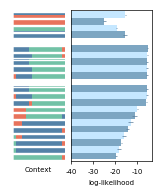

In [11]:
# plot for moderate/weak selection
if model == 'strong':
    sys.exit()
    
# select contexts we want to plot

if antibody == 'CH65':
    constant_scenarios = [tuple(["random"]*L),
                      tuple(["MA90"]*L),tuple(["SI06"]*L),tuple(["G189E"]*L),
                      tuple(["white"]*L)]

    
# sort other scenarios by likelihood
scenarios_sorted = [k for k, v in sorted(proba_from_file.items(), key=lambda item: -np.log(np.mean([a for a in item[1] if a > 1e-80]))) if not all([l == k[0] for l in k])]

if antibody == 'CH65':
    top_set = scenarios_sorted[:5]+[tuple(["white"]*L)]
    print('Optimal:',top_set[0])

    # get best examples of other orderings
    other_orderings = []
    others = []
    other_orderings.append(list(OrderedDict.fromkeys(scenarios_sorted[0])))
    for i in range(len(scenarios_sorted)):
        scenario_collapsed = list(OrderedDict.fromkeys(scenarios_sorted[i]))
        if scenario_collapsed not in other_orderings:
            other_orderings.append(scenario_collapsed)
            others.append(scenarios_sorted[i])
        

    # combine all groups
    keys = tuple((constant_scenarios + top_set + others)[::-1])
    print(len(keys))

elif antibody == '6261':
    top_set = scenarios_sorted[:18]
    print('Optimal:',top_set[0])        

    # combine all groups
    keys = tuple((constant_scenarios + top_set)[::-1])
    #print(keys)
        
likelihoods, err_likelihoods = [], []
for k in keys:
    if "white" in k:
        likelihoods += [np.nan]
        err_likelihoods += [np.nan]
    elif "random" in k:
        likelihoods += [np.mean(np.log(np.mean(proba_random_from_file,axis=1)),axis=0)]
        err_likelihoods += [np.std(np.std(proba_random_from_file,axis=1,ddof=1)/np.mean(proba_random_from_file,axis=1),ddof=1) ]
#         likelihoods += [np.log(np.mean(np.mean(proba_random,axis=1),axis=0))]
#         err_likelihoods += [(np.std(np.std(proba_random,axis=1,ddof=1),axis=0,ddof=1))/np.mean(np.mean(proba_random,axis=1),axis=0)]

    elif np.mean(proba_from_file[k]) > 0:
        likelihoods += [np.log(np.mean([a for a in proba_from_file[k]]))]
        err_likelihoods += [np.std([a for a in proba_from_file[k]],ddof=1)/np.mean([a for a in proba_from_file[k]])]

likelihoods = np.array(likelihoods)
err_likelihoods = np.array(err_likelihoods)
        
val = np.zeros((5*L, 5*len(keys)))
for ii, key in enumerate(keys):
    for jj, a in enumerate(key):
        val[5*jj:5*(jj+1), 5*ii:5*(ii+1)] = {"MA90":1, "SI06":2, "G189E":3, "H9":4, "":0, "white":-1, "random":-2}[a]

        
if antibody == '6261':        
    fig = plt.figure(constrained_layout=True, figsize=(1.6,2))
    gs = fig.add_gridspec(1,7)
    ax0 = fig.add_subplot(gs[0,0:2])
    ax = fig.add_subplot(gs[0,2:], sharey=ax0)

elif antibody == 'CH65':        
    fig = plt.figure(constrained_layout=True, figsize=(1.8,2))
    gs = fig.add_gridspec(1,5)
    ax0 = fig.add_subplot(gs[0,0:2])
    ax = fig.add_subplot(gs[0,2:], sharey=ax0)
        

# Turn off tick labels
ax0.set_yticks([])
ax0.set_xticks([])
ax0.spines['top'].set_color('white')
ax0.spines['bottom'].set_color('white')
ax0.spines['right'].set_color('white')
ax0.spines['left'].set_color('white')

colorMA90, colorSI06, colorG189E, colorH9 = "#E8735C", "#72C2A6", "#5482A7", "#663399"

pal = sns.color_palette()
colors = [colorMA90, 'white', 'xkcd:light grey', colorMA90, colorSI06, colorG189E, colorH9]
cmap = mpl.colors.ListedColormap(colors)
ax0.imshow(val.transpose(), interpolation='none', vmin=-2, vmax=4, cmap=cmap)
mpl.rcParams['hatch.linewidth'] = 5 # previous pdf hatch linewidth
mpl.rcParams['hatch.color'] = colorSI06 # previous pdf hatch linewidth


if antibody == "CH65":
    hashes = np.zeros(val.transpose().shape)
    hashes = np.arange(0, val.shape[0]*val.shape[1]).reshape(val.shape).transpose()%11 < 4
    ax0.imshow((val.transpose() == -2)*hashes, interpolation='none', cmap=mpl.colors.ListedColormap(["#FFFFFF00", colorSI06]))
    
    hashes = np.zeros(val.transpose().shape)
    hashes = np.arange(0, val.shape[0]*val.shape[1]).reshape(val.shape).transpose()%11 > 7
    ax0.imshow((val.transpose() == -2)*hashes, interpolation='none', cmap=mpl.colors.ListedColormap(["#FFFFFF00", colorG189E]))

if antibody == "6261":
    hashes = np.zeros(val.transpose().shape)
    hashes = np.arange(0, val.shape[0]*val.shape[1]).reshape(val.shape).transpose()%11 < 5
    ax0.imshow((val.transpose() == -2)*hashes, interpolation='none', cmap=mpl.colors.ListedColormap(["#FFFFFF00", colorH9]))



ax0.set_aspect('auto')
for ii in range((val.shape[1]//5+1)):
    #ax0.axhline(5*ii-1, color="white", alpha=1, lw=1)
    ax0.plot([0,5*L],[5*ii-.9,5*ii-.9],color="white", alpha=1, lw=1)
    ax0.plot([0,5*L],[5*ii-.1,5*ii-.1],color="white", alpha=1, lw=1)

ax0.set_ylim(-1, val.shape[1]+1)
ax0.set_xlim([0,5*L])
ax0.set_xlabel("Context", fontsize=5)

max_loglik = np.nanmax(np.log(likelihoods))
min_loglik = np.nanmin(np.log(likelihoods))
value_displayed = likelihoods #(-min_loglik + np.log(likelihoods))/(max_loglik - min_loglik)*0.8 + 0.1
err_values = np.nan_to_num(err_likelihoods, 0)#/(max_loglik - min_loglik)*0.8, 0)

#print(err_values)

ax.barh(width=value_displayed+40,
           y=np.arange(2.5, 5*len(likelihoods), 5), height=5., left=-40,
        color=["#7da6c2", "#c5e7ff"]*(len(likelihoods)//2))
#ax.invert_xaxis()
ax.errorbar(x=value_displayed,
           y=np.arange(2.5, 5*len(likelihoods), 5),
            xerr=err_values, color="k", markersize=10, linestyle='', elinewidth=0.5, ecolor="#5b7c99")

ax.set_xlabel("log-likelihood", fontsize=5)
#ax.set_xticklabels([])
ax.set_ylim(-1, val.shape[1]+1)

if antibody == "CH65" and model == 'moderate':
    #ax.set_xlim(-40,-10)
    ax.set_xticks([-40,-30,-20,-10])
    ax.set_xticklabels([-40,-30,-20,-10],fontsize=5)
elif antibody == "CH65" and model == 'weak' or model == 'weak2':
    ax.set_xlim(-30,0)
    ax.set_xticks([-30,-20,-10,0])
    ax.set_xticklabels([-30,-20,-10,0],fontsize=5)

elif antibody == "6261":
    ax.set_xlim(-30,0)
    ax.set_xticks([-30,-20,-10,0])
    ax.set_xticklabels([-30,-20,-10,0],fontsize=5)

plt.subplots_adjust(wspace=0.3)
   
plt.savefig(f"nonconstrained_G189E/images/context_likelihood_{antibody}_{model}_complete.pdf",dpi=1200,bbox_inches='tight')

plt.show()

## Recalculate normalized probabilities for selected contexts (no bootstrapping)

In [21]:
# Calculate normalized transition matrices 
pmut_unnormed = {}
pmut_normed = {}
for ag in tqdm(antigens+['mixed']):
    pmut_unnormed[ag] = dok_matrix((2**L, 2**L), dtype=np.float64)
    fitnesses = df[f"{ag}_log10Kd"].values.astype('float32')
    
    for s in sequences_int:
        for t in reachable(s, L):
            if is_intermediate and t != INTERMEDIATE and nb_mutation(t) == nb_mutation(INTERMEDIATE):
                pmut_unnormed[ag][s, t] = 0
            else:
                if model == 'strong':
                    pmut_unnormed[ag][s, t] = fixation_probability_binary(s,fitnesses[s],fitnesses[t])
                else:  
                    pmut_unnormed[ag][s, t] = fixation_probability_moderate(fitnesses[s],fitnesses[t],N,gamma)

    ### change format for something that can deal with multiplications
    pmut_unnormed[ag].tocsr()
    ### normalize the sparse matrix
    pmut_normed[ag] = normalize(pmut_unnormed[ag], norm='l1', axis=1)


2
('MA90', 'G189E', 'SI06', 'G189E', 'SI06', 'MA90', 'SI06', 'MA90', 'MA90', 'SI06', 'SI06', 'MA90', 'SI06', 'G189E', 'MA90', 'MA90') -13.140442362815872


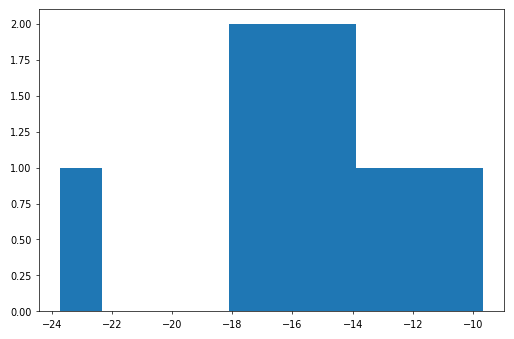

-15.543872809054715


In [12]:
#find the best and median random contexts
random_means = np.mean(proba_random_from_file,axis=1)
random_means_sorted = sorted(range(len(random_means)),key = lambda x: random_means[x])
median_random_index = random_means_sorted[int(len(random_means)/2)+2] 
print(median_random_index) #np.log(proba_random[median_random_index]))
median_random = contexts_random_from_file[median_random_index]
print(median_random,np.log(random_means[median_random_index]))

plt.hist(np.log(np.mean(proba_random_from_file,axis=1)))
plt.show()
print(np.mean(np.log(proba_random_from_file)))

In [13]:
if antibody == "CH65":
    antigen_contexts = { "optimal": ["G189E"]*5 + ["SI06"]*10 + ["MA90"]*1,
                            "MA90alone": ["MA90"]*16,  
                         "SI06alone": ["SI06"]*16,
                        "G189Ealone": ["G189E"]*16,
                         "mixed": ["mixed"]*16,
                           "random_median": median_random}

## Mutation order (Figure 5I,J, Figure 5 -- Figure Supplement 3)

In [31]:
for ac in tqdm(antigen_contexts):
    ## precompute the transition probability matrix to every power
    ## pmut_power[s, e] is the product of all normed matrix between s and e (excluded)
    pmut_power = {}
    for s in range(L+1):
        for e in range(s, L+1):
            pmut_power[s, e] = pmut_normed[antigen_contexts[ac][0]]**0 #identity matrix
            for j in range(s, e):
                pmut_power[s, e] = pmut_power[s, e]@pmut_normed[antigen_contexts[ac][j]]
                
    ## compute the matrix that force the mutation to be mut
    force_mut = {}
    for mut in range(L):
        for i in range(L):
            force_mut[(i,mut)] = dok_matrix((2**L, 2**L), dtype=np.float64)
        
        for s in sequences_int[:-1]:
            nb_mut = nb_mutation(s)
            t = mutation(s, mut, L)
            force_mut[(nb_mut,mut)][s, t] = pmut_normed[antigen_contexts[ac][nb_mut]][s, t]
        
    ## compute probabilities
    proba = np.zeros((L, L))
    for mut in range(L):
        for t in range(L):
            proba[mut, t] = (pmut_power[0, t] @ force_mut[(t,mut)] @ pmut_power[t+1, L])[0, 2**L - 1]

    ## print results to file
    if antibody == 'CH65':
        proba_df = pd.DataFrame(proba,columns=
                        ["Order 1","Order 2","Order 3","Order 4","Order 5","Order 6",
                         "Order 7","Order 8","Order 9","Order 10","Order 11","Order 12",
                        "Order 13","Order 14","Order 15","Order 16"])
        proba_df['Mutation'] = ["Mut 1","Mut 2","Mut 3","Mut 4","Mut 5","Mut 6",
                       "Mut 7","Mut 8","Mut 9","Mut 10","Mut 11",
                       "Mut 12","Mut 13","Mut 14","Mut 15","Mut 16"] 
        proba_df.to_csv(f"nonconstrained_G189E/data/CH65_probability_"+str(ac)+"_"+model+".csv",index=False)

## Figure 5 -- Figure Supplement 2

optimal



0.0 149.57768645107177
1460


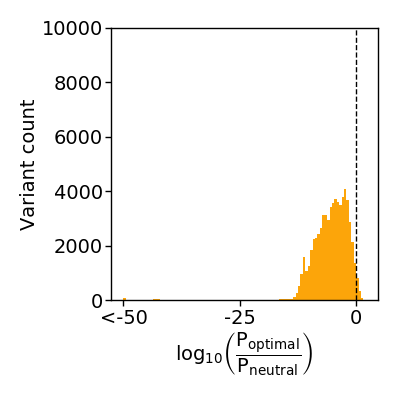

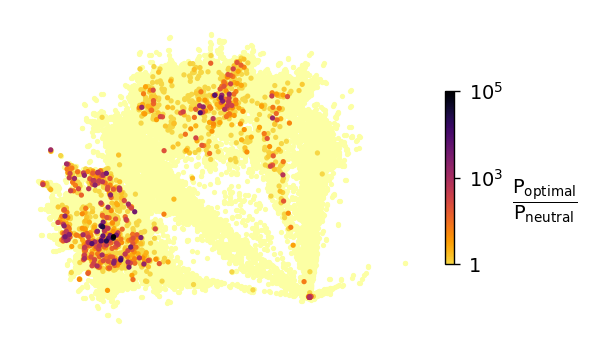

In [32]:
#### Plot probabilty of each variant in optimal context ####
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
import matplotlib.colors as colors
for context in ["optimal"]:
    print(context)
    antigen_context = antigen_contexts[context]
    ## Compute the probability of belonging to the path for each variant
    # if strong selection, use non-normalized, otherwise normalized
    if model == 'strong':
        A = {0: pmut_unnormed[antigen_context[0]]**0}
        B = {0: pmut_unnormed[antigen_context[0]]**0}
        for ii in range(1, L+1):
            A[ii] = A[ii-1]@pmut_unnormed[antigen_context[ii-1]]
            B[ii] = pmut_unnormed[antigen_context[ii-1]]@B[ii-1]
    else:
        A = {0: pmut_normed[antigen_context[0]]**0}
        B = {0: pmut_normed[antigen_context[0]]**0}
        for ii in range(1, L+1):
            A[ii] = A[ii-1]@pmut_normed[antigen_context[ii-1]]
            B[ii] = pmut_normed[antigen_context[ii-1]]@B[ii-1]
        

    proba = np.zeros(2**L)
    norm = defaultdict(int)
    for v in tqdm(sequences_int):
        if v != 0 and v != 2**L - 1:
            n = nb_mutation(v)
            proba[v] = (A[n])[0, v] * B[L - n][v, 2**L-1]
            norm[n] += 1
    for v in sequences_int:
        if model == 'strong':
            # normalize explicitly
            proba[v] = proba[v] * norm[nb_mutation(v)] /math.factorial(L)
        else:
            proba[v] = proba[v] * norm[nb_mutation(v)]
    proba[0] = 1
    proba[2**L-1] = 1
    
    #df["proba_path"] = proba 

    mpl.rcParams['figure.dpi'] = 200

    print(np.nanmin(proba),np.nanmax(proba))

    indices = np.where(proba > 0.0)[0]

    if model != 'strong':
        probas_for_plot = np.log10(proba[indices])
    too_low = np.where(probas_for_plot < -50)[0]
    probas_for_plot[too_low] = -50
    
    print(len(np.where(probas_for_plot > 0)[0]))
                         
    fig,ax = plt.subplots(figsize=(2,2))
    ax.tick_params(pad=1)
    plt.hist(probas_for_plot,bins=100,color=cm.inferno_r(0.2))
    #plt.yscale('log')
    plt.plot([0,0],[0,10000],'k--',linewidth=0.5)
    plt.ylim([0,10000])
    #plt.xlim(-102,0)
    plt.xticks([-50,-25,0,],['<-50','-25','0'])
    #plt.yticks([0,2000,4000,6000],['0','2000','4000','6000'])
    plt.xlabel(r'$\log_{10}\left(\dfrac{P_{optimal}}{P_{neutral}}\right)$',labelpad=1)
    plt.ylabel('Variant count',labelpad=1)
    plt.tight_layout()
    plt.savefig(f'{img}variantdist_'+antibody+'_'+context+'_'+model+'.pdf')
    plt.show()
    #df

    df_fdl = pd.read_csv(f"../SI06_browser/data/CH65.csv", dtype={"variant":"str"})
    df_fdl["variant_int"] = df_fdl.variant.apply(lambda x: int(x, 2))
    df_fdl = df_fdl.set_index("variant_int").reindex(range(0, 2**L)).reset_index()

    df_fdl["path_prob"] = proba

    df_fdl = df_fdl.sort_values(by=["path_prob"])

    minval = 1.0
    cmap = plt.get_cmap('inferno_r')
    new_cmap = truncate_colormap(cmap, 0.1,1)

    plt.figure(figsize=(3,3)) #plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [4, 1]})
    ax = plt.subplot(111)
    ax.scatter(x=-1.0*df_fdl.fdl_x, y=-1.0*df_fdl.fdl_y,
           s=.8, color =cmap(0.0), alpha=1)
    sc = ax.scatter(x=-1.0*df_fdl.loc[df_fdl['path_prob'] > minval,'fdl_x'], y=-1.0*df_fdl.loc[df_fdl['path_prob'] > minval,'fdl_y'],
           s=.8, c=np.log(df_fdl.loc[df_fdl['path_prob'] > minval,'path_prob']),
           cmap=new_cmap,vmin=minval,alpha=1)
    cbar = plt.colorbar(sc,fraction=0.02,ticks=[1,3,5])
    cbar.ax.set_yticklabels(['1','$10^3$','$10^5$'])
    cbar.ax.set_ylabel(r'$\dfrac{P_{optimal}}{P_{neutral}}$',rotation='horizontal',labelpad=15)
    #plt.clim(-4,4)
    ax.set_aspect('equal')


    #ax.get_legend().remove()
    ax.set_axis_off()

    plt.tight_layout()
    plt.savefig(f'nonconstrained_G189E/images/landscape_paths_'+antibody+'_'+context+'_'+model+'.png',dpi=600)
    plt.show()
    
#     sys.exit()
    
    
    

## Figure 5G,H

In [33]:
# make directed weighted graph

# store fitnesses as dict
fitnesses = {}
for a in antigens+['mixed']:
    fitnesses[a] = (df.set_index("variant_int")[f"{a}_log10Kd"]).to_dict()

df["nb_mutation"] = df.variant_int.apply(nb_mutation)

# choose number of best paths to store
num_best_paths = 25
best_paths = {}

for ac in tqdm(antigen_contexts):
    # (re) create the graph with networkx (as a directed graph)
    G = nx.DiGraph()
    G.add_nodes_from(sequences_int)
    G.add_weighted_edges_from([(s, t,  ## source, target
                                -np.log(1e-100 + pmut_normed[antigen_contexts[ac][nb_mutation(s)]][s, t])  # weight
                               ) 
                      for s in sequences_int
                      for t in reachable(s, L)])
    
    #if is_intermediate:
    #    for s in sequences_int:
    #        if s != INTERMEDIATE and nb_mutation(s) == nb_mut_int:
    #            G.remove_node(n)
    
    # compute the k shortest paths, for which ∑ -log(p) is smallest => max likelihood
    best_paths[ac] = np.empty((num_best_paths,L+1),dtype=int)
    i = 0
    for path in k_shortest_paths(G, 0, 2**L-1,num_best_paths,weight='weight'):
        best_paths[ac][i] = path
        i += 1

In [42]:
for ac in antigen_contexts:
    !rm nonconstrained_G189E/data/CH65_bestpaths_{str(ac)}_{model}.csv
    paths=[]
    for value in best_paths[ac]:
        genos=[]
        for item in value:
            genos.append(df[df['variant_int']==item]['geno'].item())
        with open(f"nonconstrained_G189E/data/CH65_bestpaths_"+str(ac)+"_"+model+".csv", "a") as fp:
            wr = csv.writer(fp, dialect='excel')
            wr.writerow(genos)

In [45]:
df2=pd.read_csv(f'nonconstrained_G189E/data/CH65_bestpaths_mixed_moderate.csv',header=None,dtype=str)
df2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0000000000000000,0000000000100000,0000000100100000,0010000100100000,0010000100100010,0011000100100010,0011100100100010,0011100100100011,0011101100100011,0011101101100011,0011101111100011,0011111111100011,0111111111100011,1111111111100011,1111111111101011,1111111111111011,1111111111111111
1,0000000000000000,0010000000000000,0010000100000000,0010000100100000,0010000100100010,0011000100100010,0011100100100010,0011100100100011,0011101100100011,0011101101100011,0011101111100011,0011111111100011,0111111111100011,1111111111100011,1111111111101011,1111111111111011,1111111111111111
2,0000000000000000,0010000000000000,0010000000100000,0010000100100000,0010000100100010,0011000100100010,0011100100100010,0011100100100011,0011101100100011,0011101101100011,0011101111100011,0011111111100011,0111111111100011,1111111111100011,1111111111101011,1111111111111011,1111111111111111
3,0000000000000000,0000000000100000,0010000000100000,0010000100100000,0010000100100010,0011000100100010,0011100100100010,0011100100100011,0011101100100011,0011101101100011,0011101111100011,0011111111100011,0111111111100011,1111111111100011,1111111111101011,1111111111111011,1111111111111111
4,0000000000000000,0000000000100000,0000000100100000,0010000100100000,0010000100100010,0011000100100010,0011100100100010,0011100100100011,0011101100100011,0011101101100011,0011101111100011,1011101111100011,1111101111100011,1111111111100011,1111111111101011,1111111111111011,1111111111111111
5,0000000000000000,0010000000000000,0010000100000000,0010000100100000,0010000100100010,0011000100100010,0011100100100010,0011100100100011,0011101100100011,0011101101100011,0011101111100011,1011101111100011,1111101111100011,1111111111100011,1111111111101011,1111111111111011,1111111111111111
6,0000000000000000,0000000000100000,0000000100100000,0010000100100000,0010000100100010,0011000100100010,0011100100100010,0011100100100011,0011101100100011,0011101101100011,0011101111100011,0111101111100011,1111101111100011,1111111111100011,1111111111101011,1111111111111011,1111111111111111
7,0000000000000000,0010000000000000,0010000100000000,0010000100100000,0010000100100010,0011000100100010,0011100100100010,0011100100100011,0011101100100011,0011101101100011,0011101111100011,0111101111100011,1111101111100011,1111111111100011,1111111111101011,1111111111111011,1111111111111111
8,0000000000000000,0010000000000000,0010000000100000,0010000100100000,0010000100100010,0011000100100010,0011100100100010,0011100100100011,0011101100100011,0011101101100011,0011101111100011,1011101111100011,1111101111100011,1111111111100011,1111111111101011,1111111111111011,1111111111111111
9,0000000000000000,0000000000100000,0000000000100010,0010000000100010,0010000100100010,0011000100100010,0011100100100010,0011100100100011,0011101100100011,0011101101100011,0011101111100011,0011111111100011,0111111111100011,1111111111100011,1111111111101011,1111111111111011,1111111111111111


In [36]:
# get Kds and delta Kds for CH65 best paths
num_to_use = 25

best_path_mean_Kds_MA90 = {}
best_path_mean_Kds_SI06 = {}
best_path_mean_Kds_G189E = {}
best_path_std_Kds_MA90 = {}
best_path_std_Kds_SI06 = {}
best_path_std_Kds_G189E = {}

best_paths_Kds_MA90 = {}
best_paths_Kds_SI06 = {}
best_paths_Kds_G189E = {}
best_paths_err_Kds_MA90 = {}
best_paths_err_Kds_SI06 = {}
best_paths_err_Kds_G189E = {}


for ac in antigen_contexts:
    best_path_means_MA90 = np.empty((num_to_use,L+1),dtype=float)
    best_path_stderr_MA90 = np.empty((num_to_use,L+1),dtype=float)
    best_path_means_SI06 = np.empty((num_to_use,L+1),dtype=float)
    best_path_stderr_SI06 = np.empty((num_to_use,L+1),dtype=float)
    best_path_means_G189E = np.empty((num_to_use,L+1),dtype=float)
    best_path_stderr_G189E = np.empty((num_to_use,L+1),dtype=float)

    for i in range(num_to_use):
        best_path_means_MA90[i,:] = [df.loc[best_paths[ac][i,n]]["MA90_log10Kd"] for n in range(L+1)]
        best_path_stderr_MA90[i,:] = [df.loc[best_paths[ac][i,n]]["MA90_stelog10Kd"] for n in range(L+1)]
        best_path_means_SI06[i,:] = [df.loc[best_paths[ac][i,n]]["SI06_log10Kd"] for n in range(L+1)]
        best_path_stderr_SI06[i,:] = [df.loc[best_paths[ac][i,n]]["SI06_stelog10Kd"] for n in range(L+1)]
        best_path_means_G189E[i,:] = [df.loc[best_paths[ac][i,n]]["G189E_log10Kd"] for n in range(L+1)]
        best_path_stderr_G189E[i,:] = [df.loc[best_paths[ac][i,n]]["G189E_stelog10Kd"] for n in range(L+1)]
    
    #best_paths_geno[ac] = best_path_geno
    best_paths_Kds_MA90[ac] = best_path_means_MA90
    best_paths_err_Kds_MA90[ac] = best_path_stderr_MA90
    best_paths_Kds_SI06[ac] = best_path_means_SI06
    best_paths_err_Kds_SI06[ac] = best_path_stderr_SI06
    best_paths_Kds_G189E[ac] = best_path_means_G189E
    best_paths_err_Kds_G189E[ac] = best_path_stderr_G189E
    
    best_path_mean_Kds_MA90[ac] = np.nanmean(best_path_means_MA90,axis=0)
    best_path_mean_Kds_SI06[ac] = np.nanmean(best_path_means_SI06,axis=0)
    best_path_mean_Kds_G189E[ac] = np.nanmean(best_path_means_G189E,axis=0)
    
    best_path_std_Kds_MA90[ac] = np.std(best_path_means_MA90,axis=0)
    best_path_std_Kds_SI06[ac] = np.std(best_path_means_SI06,axis=0)
    best_path_std_Kds_G189E[ac] = np.std(best_path_means_G189E,axis=0)

['G189E', 'G189E', 'G189E', 'G189E', 'G189E', 'SI06', 'SI06', 'SI06', 'SI06', 'SI06', 'SI06', 'SI06', 'SI06', 'SI06', 'SI06', 'MA90']
['MA90', 'MA90', 'MA90', 'MA90', 'MA90', 'MA90', 'MA90', 'MA90', 'MA90', 'MA90', 'MA90', 'MA90', 'MA90', 'MA90', 'MA90', 'MA90']
['SI06', 'SI06', 'SI06', 'SI06', 'SI06', 'SI06', 'SI06', 'SI06', 'SI06', 'SI06', 'SI06', 'SI06', 'SI06', 'SI06', 'SI06', 'SI06']
['G189E', 'G189E', 'G189E', 'G189E', 'G189E', 'G189E', 'G189E', 'G189E', 'G189E', 'G189E', 'G189E', 'G189E', 'G189E', 'G189E', 'G189E', 'G189E']
['mixed', 'mixed', 'mixed', 'mixed', 'mixed', 'mixed', 'mixed', 'mixed', 'mixed', 'mixed', 'mixed', 'mixed', 'mixed', 'mixed', 'mixed', 'mixed']
('MA90', 'G189E', 'SI06', 'G189E', 'SI06', 'MA90', 'SI06', 'MA90', 'MA90', 'SI06', 'SI06', 'MA90', 'SI06', 'G189E', 'MA90', 'MA90')


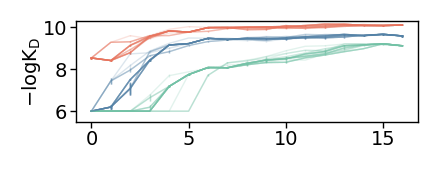

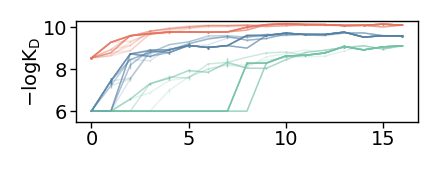

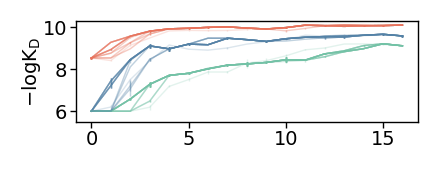

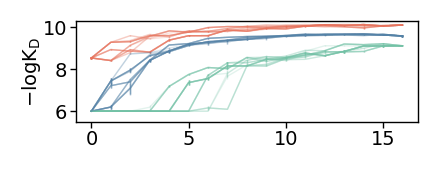

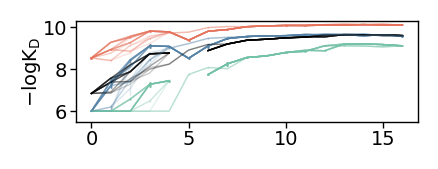

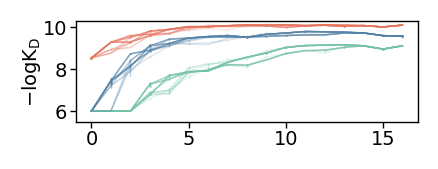

In [37]:
for context in antigen_contexts:
    print(antigen_contexts[context])
    fig,ax = plt.subplots(figsize=(2.2,0.85))
    ax.tick_params(pad=1)
    for i in range(num_best_paths):
        plt.errorbar(x=range(L+1),y=best_paths_Kds_SI06[context][i],yerr=best_paths_err_Kds_SI06[context][i],
                 color=colorSI06,alpha=0.2,linewidth=0.5)
        plt.errorbar(x=range(L+1),y=best_paths_Kds_G189E[context][i],yerr=best_paths_err_Kds_G189E[context][i],
                 color=colorG189E,alpha=0.2,linewidth=0.5)
        plt.errorbar(x=range(L+1),y=best_paths_Kds_MA90[context][i],yerr=best_paths_err_Kds_MA90[context][i],
                 color=colorMA90,alpha=0.2,linewidth=0.5)
        
        if context == "mixed":
            plt.errorbar(x=range(L+1),y=np.mean([best_paths_Kds_G189E[context][i],best_paths_Kds_SI06[context][i],best_paths_Kds_MA90[context][i]],axis=0),
                color='k',alpha=0.2,linewidth=0.5)
            
    #plt.xlabel('Number of mutations')
    plt.ylabel(f"$-logK_D$",labelpad=0)
    #plt.xticks(np.arange(0,18,2),[str(x) for x in np.arange(0,18,2)])
    plt.yticks([6,8,10],['6','8','10'])
    plt.ylim([5.5,10.3])
    plt.tight_layout()
    plt.savefig('nonconstrained_G189E/images/average_paths_'+antibody+'_'+context+'_'+model+'.pdf')

plt.show()

In [14]:
for context in antigen_contexts:
    df_mutorder = pd.read_csv('nonconstrained_G189E/data/CH65_probability_%s_moderate.csv' % context,index_col='Mutation')
    dft = df_mutorder.transpose()
    if context=="MA90alone":
        title="MA90 alone"
    if context=="SI06alone":
        title="SI06 alone"
    if context=="G189Ealone":
        title="G189E alone"
    if context=="optimal":
        title="Optimal"
    if context=="random_median":
        title="Mixed"
    dft.plot(kind='bar', stacked=True, width = 0.95,
         color = ["#66c2bd", "#1b9d9b", "#fc7864", "#d94602", 
                  "#8DA0CB","#7570B3","#E78AC3","#E7298A","#A6D854",
                  "#66A61E","#FFD92F","#E6AB02","#E5C494","#A6761D","#B3B3B3","#666666"],figsize=(3,3))
    plt.title('%s' % title, fontsize=8)
    plt.xlabel(' ')
    plt.ylabel('Probability')
    plt.yticks([])
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0,
               labels=['N26D','S29R','Y35N','Y48C','D49Y','V98I','G31D','Y33H','M34I',
                       'H35N','N52H','G57D','L83V','S84N','R85G','R87K'])
    plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],
               ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16'],fontsize=6,rotation=0)
    plt.savefig('nonconstrained_G189E/images/%s_moderate_mutorder_I2con.pdf' % context,dpi=600,bbox_inches='tight')
    plt.clf()

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>

<Figure size 300x300 with 0 Axes>